# Projekt z Inżynierii Uczenia Maszynowego
Semestr letni 2020, WEiTI PW
## Autorzy
Przemysław Stawczyk

Maciej Szulik

## Zadanie

### Treść
*Wygląda na to, że nasze firmy kurierskie czasami nie radzą sobie z dostawami. Lepiej by było, gdybyśmy wiedzieli, ile taka dostawa dla danego zamówienia może potrwać.*

### Definicja zadania biznesowego
Oszacowanie czasu dostawy na podstawie informacji o zamówieniu

#### Biznesowe kryterium sukcesu
Dobre przybliżenie prognozowanego czasu dostawy, pozwalające określić dzień dostarczenia przesyłki.

### Definicja zadania modelowania
Przewidzenie czasu dostawy w godzinach

#### Analityczne kryterium sukcesu
Dokładność przewidywanego czasu na poziomie +/- 8 godzin.

## Analiza danych

In [72]:
import datetime
import json # as pandas struggled with json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sn

import missingno as msno
from sklearn import preprocessing
%matplotlib inline

### Load files:

In [73]:
def load_file(filename):
    with open(filename, encoding="utf8") as f:
        data = f.readlines()
        data = [json.loads(line) for line in data] #convert string to dict format
        df = pd.json_normalize(data)
    return df

users = load_file(r'data/users.jsonl')# pd.read_json(r"data/users.jsonl", typ='series', lines=True, dtype='dict')
users.head(30)

,user_id,name,city,street
0,102,Oliwier Maślankiewicz,Konin,pl. Kwiatowa 03
1,103,Kajetan Karmelita,Warszawa,ulica Maczka 31
2,104,Eryk Kuncewicz,Police,ulica Krakowska 14/94
3,105,Sylwia Sabak,Radom,ulica Szpitalna 71
4,106,Inga Stępka,Mielec,aleja Liliowa 50
5,107,Filip Włodyka,Gdynia,aleja Ludowa 797
6,108,Jerzy Podgórny,Warszawa,ul. Głogowa 78
7,109,Julita Żuberek,Kutno,ul. Wesoła 214
8,110,Urszula Lepianka,Konin,al. Rataja 60
9,111,Mateusz Posmyk,Kutno,ulica Jadwigi 92


In [74]:
deliveries = load_file("data/deliveries.jsonl")
deliveries.head(30)

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2020-02-10T02:11:41,2020-02-12T13:11:41,360.0
1,20002,2020-03-18T08:22:20,None,360.0
2,20003,2020-01-21T18:07:56,2020-01-24T05:07:56,360.0
3,20004,2020-02-21T15:33:36,2020-02-24T02:33:36,NaN
4,20005,2020-03-09T14:46:19,2020-03-13T19:46:19,620.0
5,20006,2020-02-02T02:07:04,2020-02-06T07:07:04,620.0
6,20007,2020-01-20T20:33:10,2020-01-25T01:33:10,620.0
7,20008,2020-02-02T20:41:01,2020-02-05T07:41:01,360.0
8,20009,2020-01-31T02:24:21,2020-02-04T07:24:21,620.0
9,20010,2020-01-17T04:30:21,2020-01-19T15:30:21,360.0


In [75]:
sessions = load_file("data/sessions.jsonl")
sessions.head(30)

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,100001,2020-02-10T01:49:08,102.0,1081.0,VIEW_PRODUCT,0,NaN
1,100001,2020-02-10T01:52:15,102.0,NaN,VIEW_PRODUCT,0,NaN
2,100001,2020-02-10T01:56:33,102.0,1080.0,VIEW_PRODUCT,0,NaN
3,100001,2020-02-10T01:58:07,102.0,1079.0,VIEW_PRODUCT,0,NaN
4,100001,2020-02-10T02:01:33,102.0,1077.0,VIEW_PRODUCT,0,NaN
5,100001,2020-02-10T02:03:54,102.0,1003.0,VIEW_PRODUCT,0,NaN
6,100001,2020-02-10T02:04:56,102.0,1002.0,VIEW_PRODUCT,0,NaN
7,100001,2020-02-10T02:07:25,102.0,1078.0,VIEW_PRODUCT,0,NaN
8,100001,2020-02-10T02:11:41,102.0,1078.0,BUY_PRODUCT,0,20001.0
9,100002,2020-03-18T08:22:14,102.0,1318.0,VIEW_PRODUCT,0,NaN


In [76]:
products = load_file("data/products.jsonl")
products.head()

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,5.897000e+01
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2.048500e+03
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7.639000e+09
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,4.999000e+01
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,4.999000e+01


### Analiza dostarczonych plików

In [77]:
# helper functions

def generate_sparsity_matrix(dataframe):
    missing_df = dataframe.columns[dataframe.isnull().any()].tolist()
    msno.matrix(dataframe[missing_df], figsize=(20, 5))

def clean_nan_rows(dataframe, print_stats = False):
    clean_df = dataframe.dropna(axis=0, how='any')
    if print_stats:
        print('Original Length=', len(dataframe), '\tCleaned Length=', len(clean_df), '\tMissing Data=', len(dataframe) - len(clean_df))
    return clean_df

def print_null_stats(dataframe):
    total_rows = dataframe.shape[0]
    null_values = dataframe.isnull().sum(axis = 0)

    print("Total rows: ", total_rows)
    print("\nNull values per culumn:")
    print(null_values)

#### Users

In [78]:
print_null_stats(users)

Total rows:  200

Null values per culumn:
user_id    0
name       0
city       0
street     0
dtype: int64


Dane `users` przechowują informacje o id użytkownika, imieniu i nazwisku i adresie. Nie posiadają żadnych brakujących wartości.

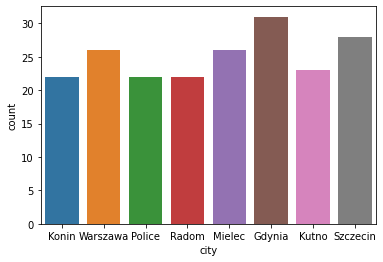

In [79]:
sn.countplot(x="city", data=users)

#### Products

In [80]:
print_null_stats(products)

negative_prices_count = products[products["price"] < 0].shape[0]

print("\nNegative prices count: ", negative_prices_count)

Total rows:  319

Null values per culumn:
product_id       0
product_name     0
category_path    0
price            0
dtype: int64

Negative prices count:  15


Dane `products` przechowują informacje o id produktu, jego nazwie, kategorii i cenie. Nie posiadają żadnych brakujących wartości. Występuje 15 przypadków, kiedy cena jest ujemna, co może budzić wątwpliwości, ale dalsza analiza tych danych w naszym przypadku nie jest konieczna, gdyż nie niosą one potrzebnych nam informacji.

#### Deliveries

Total rows:  7268

Null values per culumn:
purchase_id             0
purchase_timestamp      0
delivery_timestamp    382
delivery_company      362
dtype: int64

Brakujące czasy dostawy w deliveries:

Original Length= 7268 	Cleaned Length= 6886 	Missing Data= 382

Brakujące firmy kurierskie w deliveries:

Original Length= 7268 	Cleaned Length= 6906 	Missing Data= 362

Brakujące dane w deliveries:


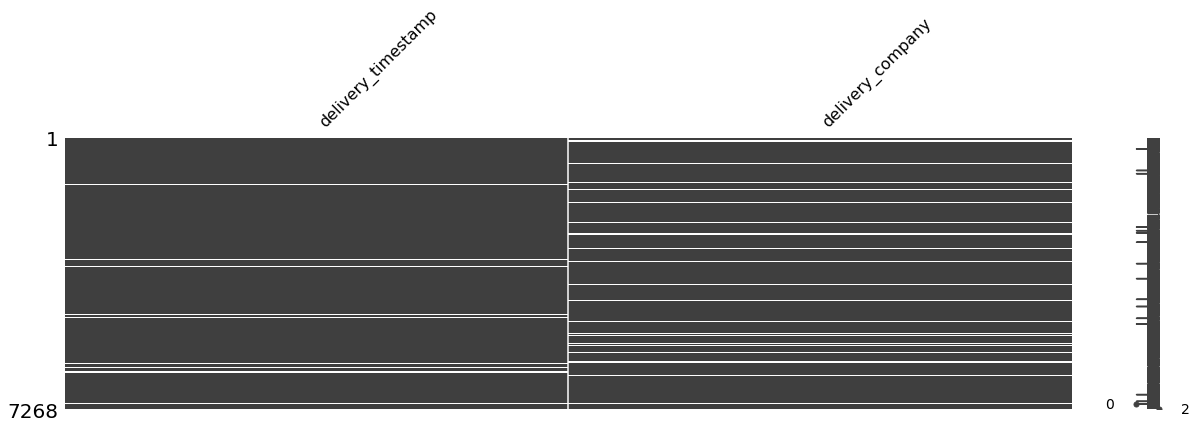

In [81]:
print_null_stats(deliveries)

print("\nBrakujące czasy dostawy w deliveries:\n")
clean_nan_rows(dataframe=deliveries['delivery_timestamp'], print_stats=True)

print("\nBrakujące firmy kurierskie w deliveries:\n")
clean_nan_rows(dataframe=deliveries['delivery_company'], print_stats=True)

print("\nBrakujące dane w deliveries:")
generate_sparsity_matrix(deliveries)

Dane `deliveries` przechowują informacje o id zakupu (powiązane z `purchase_id` w `sessions`), czasie złożenia zamowienia, czasie dostawy i firmie kurierskiej, która realizowała przesyłkę. Są to dla nas dane szczególnie istotne. Uwagę zwracają brakujące czasy dostawy (`delivery_timestamp`) dla 382 rekordów i brak identyfikatora firmy kurierskiej (`delivery_company`) dla 362, co może być dla nas problemem.

##### Analiza firm kurierskich

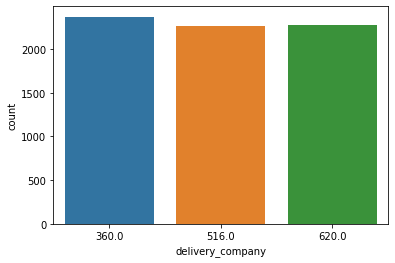

In [82]:
deliveries["delivery_company"].value_counts()
sn.countplot(x="delivery_company", data=deliveries)

Przesyłki obsługują 3 firmy kurierskie, realizując zbliżoną liczbę zamówień.

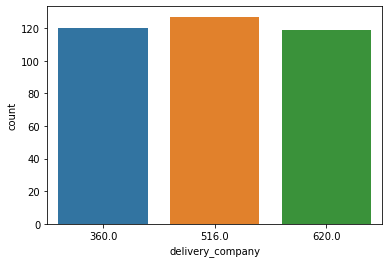

In [83]:
a = deliveries[deliveries["delivery_timestamp"].isnull()] 
sn.countplot(x="delivery_company", data=a)

Rozkład braków w `delivery_timestamp` jest zbliżony dla każdej z firm.

#### Dodatkowe analizy

In [84]:
deliveries[deliveries["purchase_timestamp"] > deliveries["delivery_timestamp"]].shape[0]

0

Nie występują anomalie, kiedy zamówienie wystąpiło później niż czas dostawy.

### Sessions

In [85]:
print_null_stats(sessions)

Total rows:  39746

Null values per culumn:
session_id              0
timestamp               0
user_id              1953
product_id           1999
event_type              0
offered_discount        0
purchase_id         32478
dtype: int64


Dane `sessions` przechowują informacje o zarejestrowanych zdarzeniach związanych z produktami, a dokładniej są to: id sesji, czas jej utworzenia, id użytkownika powiązane z sesją, id produktu, proponowana promocja na produkt, typ zdarzenia (produkt kupiony, produkt zobaczony) i powiązane id zakupu.

Interesują nas zdarzenia dotyczące kupionych produktów, bo tylko takie są dostarczane.

Te dane są dla nas kluczowe, ponieważ pozwalają powiązać dostawę (poprzez wartość `purchase_id`) z użytkownikiem (poprzez wartość `user_id`), a co za tym idzie z adresem.

Należy zatem sprawdzić, czy takie złączenie jest zawsze możliwe.

##### Analiza kupionych produktów

Upewnijmy się, że zdarzeniu `BUY_PRODUCT` zawsze odpowiada jakieś `purchase_id`.

In [86]:
sessions[(sessions["event_type"] == "BUY_PRODUCT") & (sessions["purchase_id"].isnull())].shape[0]

0

Wyselekcjonujmy z `sessions` tylko interesujące nas zdarzenia (dotyczące zdarzenia `BUY_PRODUCT`) i sprawdźmy braki danych.

Brakujące user_id w sessions dla zdarzenia BUY_PRODUCT

Original Length= 7268 	Cleaned Length= 6914 	Missing Data= 354

Brakujące dane w sessions dla operacji BUY_PRODUCT:


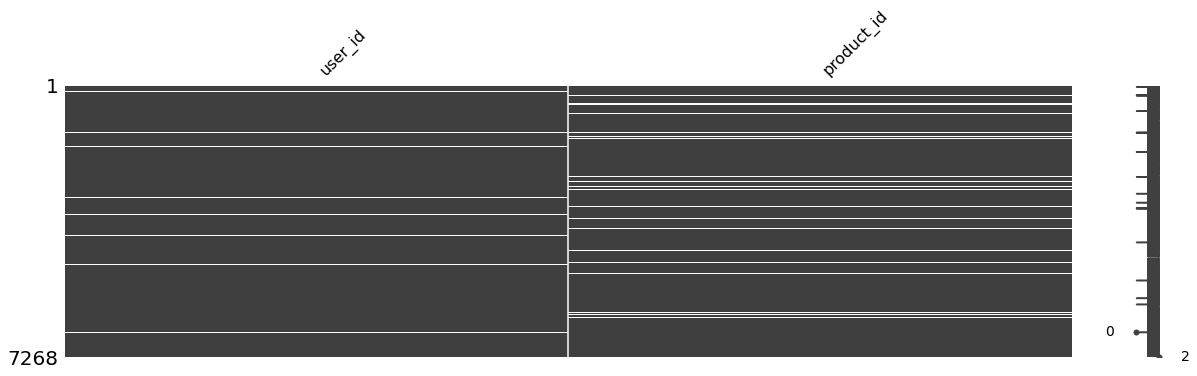

In [87]:
buy_sessions = sessions[sessions.event_type == 'BUY_PRODUCT']

print("Brakujące user_id w sessions dla zdarzenia BUY_PRODUCT\n")
clean_nan_rows(dataframe=buy_sessions['user_id'], print_stats=True)

print("\nBrakujące dane w sessions dla operacji BUY_PRODUCT:")
generate_sparsity_matrix(buy_sessions)

Jak widać nie wszystkie sesje zakończone zakupem posiadają id użytkownika, co mogłoby być przydatne do ustalenia adresu dostawy.

Taki brak da się jednak uzupełnić, jeśli dla danej sesji istnieje inna akcja, w której id użytkownika jest znane.

**Przykład:**

```json
{"session_id": 100007, "timestamp": "2020-02-02T02:03:15", "user_id": 102, "product_id": 1045, "event_type": "VIEW_PRODUCT", "offered_discount": 20, "purchase_id": null}


{"session_id": 100007, "timestamp": "2020-02-02T02:07:04", "user_id": null, "product_id": 1045, "event_type": "BUY_PRODUCT", "offered_discount": 20, "purchase_id": 20006}
```

Chociaż dla zakupu o id `20006` nie jest zdefiniowane `user_id`, to z całej sesji o id `100007` możemy to wywnioskować i uzupełnić brak ustawiając `user_id` na `102`.


Jeśli to możliwe, należy takie dane uzupełnić.

### Transformacje

Dokonajmy potrzebnych tranformacji na danych.

#### Podział na kategorię główną i podkategorię

In [88]:
category_path_arr = products['category_path'].str.split(';', 2)
category_arr = []
subcategory_arr = []
for path in category_path_arr:
    if type(path) == float:
        category_arr.append(path)
        subcategory_arr.append(path)
    else:
        category_arr.append(path[0])
        subcategory_arr.append(path[1])

products['category'] = category_arr
products['subcategory'] = subcategory_arr

products

,product_id,product_name,category_path,price,category,subcategory
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,5.897000e+01,Telefony i akcesoria,Telefony stacjonarne
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2.048500e+03,Komputery,Drukarki i skanery
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7.639000e+09,Komputery,Drukarki i skanery
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,4.999000e+01,Gry i konsole,Gry na konsole
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,4.999000e+01,Gry i konsole,Gry na konsole
...,...,...,...,...,...,...
314,1315,Jabra Talk,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,5.499000e+01,Telefony i akcesoria,Akcesoria telefoniczne
315,1316,Plantronics Voyager Legend,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,-2.490000e+02,Telefony i akcesoria,Akcesoria telefoniczne
316,1317,Plantronics Savi W740,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,1.303960e+03,Telefony i akcesoria,Akcesoria telefoniczne
317,1318,Plantronics Savi W710,Sprzęt RTV;Audio;Słuchawki,5.530000e+02,Sprzęt RTV,Audio


#### Wypelnienie braków `user_id` w `sessions`

In [89]:
session_user_map=sessions[sessions["user_id"].notna()].set_index('session_id')['user_id'].to_dict()

for i, row in sessions.iterrows():
    if np.isnan(row["user_id"]) and row["session_id"] in session_user_map:
            sessions.at[i,'user_id'] = session_user_map[row["session_id"]]
            
buy_sessions = sessions[sessions.event_type == 'BUY_PRODUCT']

clean_nan_rows(dataframe=buy_sessions['user_id'], print_stats=True)

buy_sessions

Original Length= 7268 	Cleaned Length= 7265 	Missing Data= 3


,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
8,100001,2020-02-10T02:11:41,102.0,1078.0,BUY_PRODUCT,0,20001.0
10,100002,2020-03-18T08:22:20,102.0,1318.0,BUY_PRODUCT,0,20002.0
19,100003,2020-01-21T18:07:56,102.0,1046.0,BUY_PRODUCT,10,20003.0
22,100005,2020-02-21T15:33:36,102.0,1001.0,BUY_PRODUCT,15,20004.0
27,100006,2020-03-09T14:46:19,102.0,1201.0,BUY_PRODUCT,0,20005.0
...,...,...,...,...,...,...,...
39717,110434,2020-02-28T13:13:00,301.0,1077.0,BUY_PRODUCT,0,27264.0
39722,110436,2020-02-16T21:22:58,301.0,1037.0,BUY_PRODUCT,10,27265.0
39725,110437,2020-02-24T11:35:37,301.0,1012.0,BUY_PRODUCT,15,27266.0
39735,110439,2020-01-31T23:34:46,301.0,1007.0,BUY_PRODUCT,10,27267.0


Dzięki takiej operacji, liczba wierszy z brakiem `user_id` zmniejszyła się z 354 do 3. Z pozostałymi nie da się nic już zrobić, więc je usuniemy.

In [90]:
buy_sessions = buy_sessions[buy_sessions["user_id"].notna()]
buy_sessions

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
8,100001,2020-02-10T02:11:41,102.0,1078.0,BUY_PRODUCT,0,20001.0
10,100002,2020-03-18T08:22:20,102.0,1318.0,BUY_PRODUCT,0,20002.0
19,100003,2020-01-21T18:07:56,102.0,1046.0,BUY_PRODUCT,10,20003.0
22,100005,2020-02-21T15:33:36,102.0,1001.0,BUY_PRODUCT,15,20004.0
27,100006,2020-03-09T14:46:19,102.0,1201.0,BUY_PRODUCT,0,20005.0
...,...,...,...,...,...,...,...
39717,110434,2020-02-28T13:13:00,301.0,1077.0,BUY_PRODUCT,0,27264.0
39722,110436,2020-02-16T21:22:58,301.0,1037.0,BUY_PRODUCT,10,27265.0
39725,110437,2020-02-24T11:35:37,301.0,1012.0,BUY_PRODUCT,15,27266.0
39735,110439,2020-01-31T23:34:46,301.0,1007.0,BUY_PRODUCT,10,27267.0


#### Usunięcie/wypełnienie brakow w `deliveries`

In [91]:
# TODO

#### Złączenie tabel

In [92]:
# inner join sessins and deliveries
merged_data = pd.merge(left=sessions, right=deliveries, left_on='purchase_id', right_on='purchase_id')

# left join users
merged_data = pd.merge(left=merged_data, right=users, how='left', left_on='user_id', right_on='user_id')

# left join products
merged_data = pd.merge(left=merged_data, right=products, how='left', left_on='product_id', right_on='product_id')

merged_data

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,name,city,street,product_name,category_path,price,category,subcategory
0,100001,2020-02-10T02:11:41,102.0,1078.0,BUY_PRODUCT,0,20001.0,2020-02-10T02:11:41,2020-02-12T13:11:41,360.0,Oliwier Maślankiewicz,Konin,pl. Kwiatowa 03,Kyocera FS-3540MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,5.126000e+03,Komputery,Drukarki i skanery
1,100002,2020-03-18T08:22:20,102.0,1318.0,BUY_PRODUCT,0,20002.0,2020-03-18T08:22:20,None,360.0,Oliwier Maślankiewicz,Konin,pl. Kwiatowa 03,Plantronics Savi W710,Sprzęt RTV;Audio;Słuchawki,5.530000e+02,Sprzęt RTV,Audio
2,100003,2020-01-21T18:07:56,102.0,1046.0,BUY_PRODUCT,10,20003.0,2020-01-21T18:07:56,2020-01-24T05:07:56,360.0,Oliwier Maślankiewicz,Konin,pl. Kwiatowa 03,LEGO Batman 2 DC Super Heroes (PS3),Gry i konsole;Gry na konsole;Gry PlayStation3,6.118000e+01,Gry i konsole,Gry na konsole
3,100005,2020-02-21T15:33:36,102.0,1001.0,BUY_PRODUCT,15,20004.0,2020-02-21T15:33:36,2020-02-24T02:33:36,NaN,Oliwier Maślankiewicz,Konin,pl. Kwiatowa 03,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,5.897000e+01,Telefony i akcesoria,Telefony stacjonarne
4,100006,2020-03-09T14:46:19,102.0,1201.0,BUY_PRODUCT,0,20005.0,2020-03-09T14:46:19,2020-03-13T19:46:19,620.0,Oliwier Maślankiewicz,Konin,pl. Kwiatowa 03,Jabra Speak 410,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,3.274700e+02,Telefony i akcesoria,Akcesoria telefoniczne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7263,110434,2020-02-28T13:13:00,301.0,1077.0,BUY_PRODUCT,0,27264.0,2020-02-28T13:13:00,2020-03-04T15:13:00,620.0,Ada Laszkiewicz,Szczecin,ul. Sportowa 70,Kyocera FS-C2026MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,3.777000e+03,Komputery,Drukarki i skanery
7264,110436,2020-02-16T21:22:58,301.0,1037.0,BUY_PRODUCT,10,27265.0,2020-02-16T21:22:58,2020-02-20T10:22:58,360.0,Ada Laszkiewicz,Szczecin,ul. Sportowa 70,LCD Asus VK248H,Komputery;Monitory;Monitory LCD,7.990000e+08,Komputery,Monitory
7265,110437,2020-02-24T11:35:37,301.0,1012.0,BUY_PRODUCT,15,27266.0,2020-02-24T11:35:37,2020-02-29T13:35:37,620.0,Ada Laszkiewicz,Szczecin,ul. Sportowa 70,Fallout New Vegas (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,6.900000e+01,Gry i konsole,Gry na konsole
7266,110439,2020-01-31T23:34:46,301.0,1007.0,BUY_PRODUCT,10,27267.0,2020-01-31T23:34:46,2020-02-04T12:34:46,360.0,Ada Laszkiewicz,Szczecin,ul. Sportowa 70,Dead Space 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,8.999000e+01,Gry i konsole,Gry na konsole


#### Odrzucenie niepotrzebnych kolumn

Odrzućmy część kolumn, które zdają się być zbędne:
- id sesji - kolumna identyfikacyjna
- id zakupu - kolumna identyfikacyjna
- id użytkownika - kolumna identyfikacyjna
- id produktu - kolumna identyfikacyjna, zbyt rozdrobniona
- product name - nazwa produktu jest zbyt rozdrobniona *[zbyt wiele różnych wartości]*, kategoria do 2 poziomu wydaje się być dobrym zastępstwem
- typ zdarzenia - rozpatrujemy wyłącznie zakup
- oferowana obniżka - nie ma znaczenia na dostawę *(opcjonalnie jako wart binarna)*
- imie i nazwisko użytkownika - konkretny użytkownik nie powinien być powiązany z dostawą
- timestamp sesji - interesuje nas czas dostawy od czasu *zakupu* do *dostarczenia*
- ulica - zbyt rozdrobniona kolumna *[zbyt wiele różnych wartości]*


In [93]:
columns = ['session_id', 'purchase_id','user_id', 'product_id', 'event_type',
           'offered_discount', 'name', 'timestamp', 'product_name', 'street']
for col in columns:
    merged_data = merged_data.drop(col, axis=1)

merged_data


,purchase_timestamp,delivery_timestamp,delivery_company,city,category_path,price,category,subcategory
0,2020-02-10T02:11:41,2020-02-12T13:11:41,360.0,Konin,Komputery;Drukarki i skanery;Biurowe urządzeni...,5.126000e+03,Komputery,Drukarki i skanery
1,2020-03-18T08:22:20,None,360.0,Konin,Sprzęt RTV;Audio;Słuchawki,5.530000e+02,Sprzęt RTV,Audio
2,2020-01-21T18:07:56,2020-01-24T05:07:56,360.0,Konin,Gry i konsole;Gry na konsole;Gry PlayStation3,6.118000e+01,Gry i konsole,Gry na konsole
3,2020-02-21T15:33:36,2020-02-24T02:33:36,NaN,Konin,Telefony i akcesoria;Telefony stacjonarne,5.897000e+01,Telefony i akcesoria,Telefony stacjonarne
4,2020-03-09T14:46:19,2020-03-13T19:46:19,620.0,Konin,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,3.274700e+02,Telefony i akcesoria,Akcesoria telefoniczne
...,...,...,...,...,...,...,...,...
7263,2020-02-28T13:13:00,2020-03-04T15:13:00,620.0,Szczecin,Komputery;Drukarki i skanery;Biurowe urządzeni...,3.777000e+03,Komputery,Drukarki i skanery
7264,2020-02-16T21:22:58,2020-02-20T10:22:58,360.0,Szczecin,Komputery;Monitory;Monitory LCD,7.990000e+08,Komputery,Monitory
7265,2020-02-24T11:35:37,2020-02-29T13:35:37,620.0,Szczecin,Gry i konsole;Gry na konsole;Gry Xbox 360,6.900000e+01,Gry i konsole,Gry na konsole
7266,2020-01-31T23:34:46,2020-02-04T12:34:46,360.0,Szczecin,Gry i konsole;Gry na konsole;Gry Xbox 360,8.999000e+01,Gry i konsole,Gry na konsole


#### Kolumny wyliczane.
Przydatny będzie właściwy czas dostawy, wyrażany np. w godzinach.

In [94]:
merged_data['delivery_timestamp'] = \
    pd.to_datetime(merged_data.delivery_timestamp)
merged_data['purchase_timestamp'] = \
    pd.to_datetime(merged_data.purchase_timestamp)
merged_data['delivery_total_time'] = \
    merged_data['delivery_timestamp'] - merged_data['purchase_timestamp']

merged_data['delivery_total_time_hours'] = \
    merged_data['delivery_total_time'].dt.total_seconds()/3600

print(merged_data[['delivery_total_time','delivery_total_time_hours']])

     delivery_total_time  delivery_total_time_hours
0        2 days 11:00:00                       59.0
1                    NaT                        NaN
2        2 days 11:00:00                       59.0
3        2 days 11:00:00                       59.0
4        4 days 05:00:00                      101.0
...                  ...                        ...
7263     5 days 02:00:00                      122.0
7264     3 days 13:00:00                       85.0
7265     5 days 02:00:00                      122.0
7266     3 days 13:00:00                       85.0
7267     3 days 17:00:00                       89.0

[7268 rows x 2 columns]


### Dalsza analiza

##### Rozkład czasu dostawy w godzinach w zależności od firmy kurierskiej

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/przemek/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


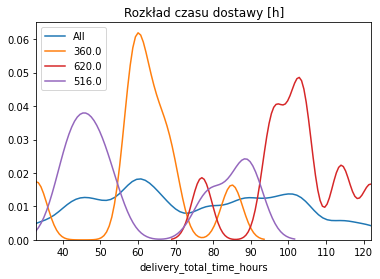

In [95]:
max_h = merged_data["delivery_total_time_hours"].max()
min_h = merged_data["delivery_total_time_hours"].min()

plt.title("Rozkład czasu dostawy [h]")

sn.distplot(merged_data["delivery_total_time_hours"], hist=False, label="All").set(xlim=(min_h, max_h))

for company in merged_data["delivery_company"].unique():
    sn.distplot(merged_data[merged_data["delivery_company"] == company]["delivery_total_time_hours"],hist=False, label=str(company)).set(xlim=(min_h, max_h))

##### Miasto a firma kurierska

sn.countplot(y="delivery_company", hue="city", data=merged_data)

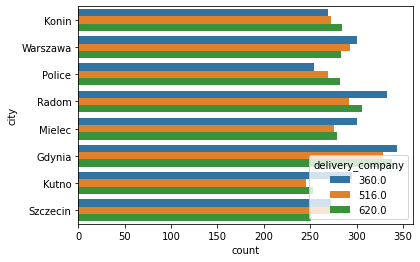

In [96]:
sn.countplot(y="city", hue="delivery_company", data=merged_data)

##### Miasto a firma kurierska dla brakujących czasów dostawy

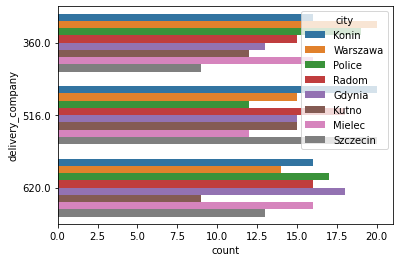

In [97]:
merge_data_nulls = merged_data[merged_data["delivery_timestamp"].isnull()]

sn.countplot(y="delivery_company", hue="city", data=merge_data_nulls)

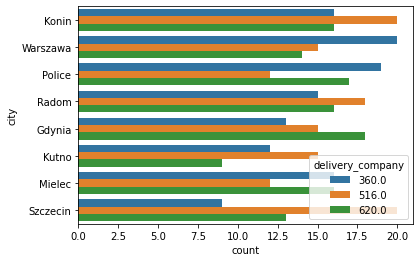

In [98]:
sn.countplot(y="city", hue="delivery_company", data=merge_data_nulls)

#### Analiza związku z celem
- ciąg dalszy na końcu

In [99]:
from sklearn.feature_selection import mutual_info_regression, f_regression

test_data = merged_data
columns = ['purchase_timestamp', 'delivery_timestamp', 'category_path']
for col in columns:
    test_data = test_data.drop(col, axis=1)

target = test_data['delivery_total_time_hours']
data = test_data.drop(['delivery_total_time','delivery_total_time_hours'], axis=1)


# fill missing and code labels
data['category'] = data['category'].fillna('missing') 
data['subcategory'] = data['subcategory'].fillna('missing') 
data['city'] = data['city'].fillna('missing') 
data = data.fillna(0)
target = target.fillna(0)

le_cat = preprocessing.LabelEncoder()
le_cat.fit(np.unique(np.array(data['category'])))
data['category'] = le_cat.transform(data['category'])

le_subcat = preprocessing.LabelEncoder()
le_subcat.fit(np.unique(np.array(data['subcategory'])))
data['subcategory'] = le_subcat.transform(data['subcategory'])

le_city = preprocessing.LabelEncoder()
le_city.fit(np.unique(np.array(data['city'])))
data['city'] = le_city.transform(data['city'])

mi = mutual_info_regression(data, target)

ft = f_regression(data, target)

feature_selection = pd.DataFrame.from_records([mi, ft[0], ft[1]], columns=data.columns.to_numpy(), index=['Mutual info','F test','F p-val'])
feature_selection

,delivery_company,city,price,category,subcategory
Mutual info,9.977469e-01,1.859269e+00,0.009749,0.000000,0.010469
F test,9.258545e+02,1.664109e+02,0.860405,0.131999,0.003116
F p-val,1.632136e-191,1.163040e-37,0.353656,0.716379,0.955489


### simple base model experiment
- no imputation, no parameter scaling

In [100]:
clean_data = merged_data

# information form these columns has been transferred to delivery_total_time and category + subcategory
columns = ['purchase_timestamp', 'delivery_timestamp', 'category_path']
for col in columns:
    clean_data = clean_data.drop(col, axis=1)

clean_data = clean_data.dropna(axis=0, how='any')

target = clean_data['delivery_total_time_hours']
data = clean_data.drop(['delivery_total_time','delivery_total_time_hours'], axis=1)

# code labels
le_cat = preprocessing.LabelEncoder()
le_cat.fit(np.unique(np.array(data['category'])))
data['category'] = le_cat.transform(data['category'])

le_subcat = preprocessing.LabelEncoder()
le_subcat.fit(np.unique(np.array(data['subcategory'])))
data['subcategory'] = le_subcat.transform(data['subcategory'])

le_city = preprocessing.LabelEncoder()
le_city.fit(np.unique(np.array(data['city'])))
data['city'] = le_city.transform(data['city'])

In [101]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor

from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

def train_tree_reg(data, target, k_model, k_fold_ratio=5, rand=3228):
    k_fold = KFold(n_splits=k_fold_ratio, random_state=rand, shuffle=True)
    data_arr = np.array(data)
    target_arr = np.array(target)

    max_errors = []
    mean_absolute_errors = []
    mean_squared_errors = []

    for train_index, test_index in k_fold.split(data_arr):
        train_X, valid_X = data_arr[train_index], data_arr[test_index]
        train_y, valid_y = target_arr[train_index], target_arr[test_index]

        k_model = k_model.fit(train_X, train_y)

        k_predict = k_model.predict(valid_X)

        # code for calculating metrics
        max_errors.append(max_error(valid_y, k_predict))
        mean_absolute_errors.append(mean_absolute_error(valid_y, k_predict))
        mean_squared_errors.append(mean_squared_error(valid_y, k_predict))

    # train resulting model
    k_model.fit(data, target)

    return k_model, \
           np.max(max_errors), \
           np.average(mean_absolute_errors), \
           np.average(mean_squared_errors)

# test data
x_train, x_test, y_train, y_test = \
    train_test_split(data, target, test_size=0.2, random_state=0)

#### KNeighborsRegressor

In [102]:
data_knn_reg = []

for weight in ['uniform', 'distance']:
    for i in [2, 3, 4, 6, 8, 12]:
        line = []

        k_model = KNeighborsRegressor(n_neighbors=i, weights=weight)

        line.append(i), line.append(weight)

        model, err, avg, avg_sqr = train_tree_reg(x_train, y_train, k_model, 10)

        line.append(err),line.append(avg),line.append(avg_sqr)

        test_predictions = model.predict(x_test)

        err = max_error(y_test, test_predictions)
        avg = mean_absolute_error(y_test, test_predictions)
        avg_sqr = mean_squared_error(y_test, test_predictions)

        line.append(err),line.append(avg),line.append(avg_sqr)
        
        data_knn_reg.append(line)

knn_reg = pd.DataFrame.from_records(data_knn_reg, columns=['k', 'weights', 'learn max error', 'learn avg error', 'learn avg sqr error', 'test max error', 'test avg error', 'test avg sqr error'])

knn_reg

,k,weights,learn max error,learn avg error,learn avg sqr error,test max error,test avg error,test avg sqr error
0,2,uniform,52.000000,3.340351,87.955278,52.000000,3.099274,78.401937
1,3,uniform,52.000000,4.323664,100.281085,48.000000,4.138284,94.460407
2,4,uniform,52.000000,5.112446,111.494739,47.500000,4.964891,111.154459
3,6,uniform,47.833333,6.353018,128.070048,47.333333,5.971751,124.398664
4,8,uniform,46.500000,7.409053,144.412634,46.750000,6.957526,136.273519
5,12,uniform,48.666667,9.049582,174.262867,41.666667,8.387342,159.387729
6,2,distance,52.000000,1.958318,64.227880,52.000000,1.573224,51.942002
7,3,distance,52.000000,1.873680,57.163234,49.285714,1.468599,45.189251
8,4,distance,52.000000,1.802485,52.625961,47.500000,1.422930,42.228175
9,6,distance,49.727273,1.693296,46.551466,47.333333,1.296831,35.428050


#### DecisionTreeRegressor

In [ ]:
data_tree_reg = []

tree_features_importances = []
index_features_importances = []

for i in range(1,7):
    line = []
    k_model = DecisionTreeRegressor(max_depth=i)

    model, err, avg, avg_sqr = train_tree_reg(x_train, y_train, k_model, 10)

    line.append(i),line.append(err),line.append(avg),line.append(avg_sqr)

    test_predictions = model.predict(x_test)

    err = max_error(y_test, test_predictions)
    avg = mean_absolute_error(y_test, test_predictions)
    avg_sqr = mean_squared_error(y_test, test_predictions)

    line.append(err),line.append(avg),line.append(avg_sqr)

    data_tree_reg.append(line)
    
    tree_features_importances.append(model.feature_importances_)
    index_features_importances.append("tree max_depth = " + str(i))

tree_reg = pd.DataFrame.from_records(data_tree_reg, columns=['depth', 'learn max error', 'learn avg error', 'learn avg sqr error', 'test max error', 'test avg error', 'test avg sqr error'])

tree_reg

#### Analiza związku z celem c.d.

In [ ]:
feature_selection = pd.concat([feature_selection, pd.DataFrame.from_records(tree_features_importances, index=index_features_importances, columns=data.columns.to_numpy())])
feature_selection


Jak widać modele drzewiaste polegają w zupełności na kolumnach miasta i firmy kurierskiej do oceny czasu dostawy. Współczynnik 

In [113]:
data_tree_reg = []

tree_features_importances = []
index_features_importances = []

for i in range(1,7):
    line = []
    k_model = DecisionTreeRegressor(max_depth=i)

    model, err, avg, avg_sqr = train_tree_reg(x_train, y_train, k_model, 10)

    line.append(i),line.append(err),line.append(avg),line.append(avg_sqr)

    test_predictions = model.predict(x_test)

    err = max_error(y_test, test_predictions)
    avg = mean_absolute_error(y_test, test_predictions)
    avg_sqr = mean_squared_error(y_test, test_predictions)

    line.append(err),line.append(avg),line.append(avg_sqr)

    data_tree_reg.append(line)
    
    tree_features_importances.append(model.feature_importances_)
    index_features_importances.append("tree max_depth = " + str(i))

tree_reg = pd.DataFrame.from_records(data_tree_reg, columns=['depth', 'learn max error', 'learn avg error', 'learn avg sqr error', 'test max error', 'test avg error', 'test avg sqr error'])

tree_reg

,depth,learn max error,learn avg error,learn avg sqr error,test max error,test avg error,test avg sqr error
0,1,28.469722,12.202460,238.009965,28.307831,11.941011,232.774982
1,2,24.291266,9.794916,154.225291,24.180249,9.810329,155.249145
2,3,27.745333,6.530451,95.783551,27.605263,6.366340,90.963050
3,4,23.592617,5.780807,71.018446,23.488513,5.689710,69.347223
4,5,18.008961,3.482028,34.033648,17.940226,3.435833,33.018245
5,6,8.379233,1.355137,8.733450,8.248447,1.401610,8.869202


#### Analiza związku z celem c.d.

In [115]:
feature_selection = pd.concat([feature_selection, pd.DataFrame.from_records(tree_features_importances, index=index_features_importances, columns=data.columns.to_numpy())])
feature_selection


,delivery_company,city,price,category,subcategory
Mutual info,9.977469e-01,1.859269e+00,0.009749,0.000000,0.010469
F test,9.258545e+02,1.664109e+02,0.860405,0.131999,0.003116
F p-val,1.632136e-191,1.163040e-37,0.353656,0.716379,0.955489
treee max_depth = 1,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
treee max_depth = 2,8.121976e-01,1.878024e-01,0.000000,0.000000,0.000000
treee max_depth = 3,7.224641e-01,2.775359e-01,0.000000,0.000000,0.000000
treee max_depth = 4,6.892271e-01,3.107729e-01,0.000000,0.000000,0.000000
treee max_depth = 5,6.705681e-01,3.294319e-01,0.000000,0.000000,0.000000
treee max_depth = 6,6.561257e-01,3.438743e-01,0.000000,0.000000,0.000000


Jak widać modele drzewiaste polegają w zupełności na kolumnach miasta i firmy kurierskiej do oceny czasu dostawy. Współczynnik 